In [14]:
# === CELL 1: SETUP & IMPORTS ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("🚀 BTC SMA-Based Dynamic Spread Strategy")
print("📊 Complete Trading Simulation & Backtesting")
print("=" * 60)

🚀 BTC SMA-Based Dynamic Spread Strategy
📊 Complete Trading Simulation & Backtesting


In [15]:
# Trading Parameters
CONFIG = {
    'BASE_PRICE': 107000,
    'TOTAL_CANDLES': 96,  # 24 hours * 4 candles per hour
    'TIMEFRAME': '15min',
    'START_DATE': '2025-06-28',

    # Strategy Parameters
    'LEVERAGE': 5,
    'POSITION_SIZE': 0.00035,  # BTC per trade
    'TAKE_PROFIT': 0.0008,     # 0.08%
    'STOP_LOSS': 0.0003,       # 0.03%
    'STARTING_BALANCE': 1000,  # USDT

    # SMA Parameters
    'SMA_PERIODS': [5, 15, 30],
    'TREND_THRESHOLD': 0.0005,  # 0.05%

    # === NEW: Trading Fees Configuration ===
    'TAKER_FEE': 0.00045,      # 0.045% taker fee
    'MAKER_FEE': 0.00015,      # 0.015% maker fee

    # === NEW: Funding Rate Configuration ===
    'INTEREST_RATE': 0.0001,   # 0.01% per funding interval
    'FUNDING_INTERVAL_HOURS': 1,  # Funding paid every hour
    'PREMIUM_VOLATILITY': 0.0002,  # Simulated premium volatility

    # Random seed for reproducible results
    'SEED': 12345
}

# Display configuration
print("📋 Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")


📋 Configuration:
   BASE_PRICE: 107000
   TOTAL_CANDLES: 96
   TIMEFRAME: 15min
   START_DATE: 2025-06-28
   LEVERAGE: 5
   POSITION_SIZE: 0.00035
   TAKE_PROFIT: 0.0008
   STOP_LOSS: 0.0003
   STARTING_BALANCE: 1000
   SMA_PERIODS: [5, 15, 30]
   TREND_THRESHOLD: 0.0005
   TAKER_FEE: 0.00045
   MAKER_FEE: 0.00015
   INTEREST_RATE: 0.0001
   FUNDING_INTERVAL_HOURS: 1
   PREMIUM_VOLATILITY: 0.0002
   SEED: 12345


In [16]:
# === CELL 3: DATA GENERATION CLASS ===
class BTCDataGenerator:
    """Generate realistic BTC price data for backtesting"""

    def __init__(self, config):
        self.config = config
        np.random.seed(config['SEED'])

    def generate_candles(self):
        """Generate realistic OHLC candles"""
        print("\n🔢 Generating BTC price data...")

        candles = []
        current_price = self.config['BASE_PRICE']
        start_time = datetime.strptime(self.config['START_DATE'], '%Y-%m-%d')

        for i in range(self.config['TOTAL_CANDLES']):
            # Calculate timestamp
            timestamp = start_time + timedelta(minutes=i * 15)

            # Generate realistic price movement
            volatility = 0.001 + np.random.random() * 0.002  # 0.1-0.3%
            direction = 1 if np.random.random() > 0.5 else -1
            change = current_price * volatility * direction

            # Calculate OHLC
            open_price = current_price
            close_price = current_price + change
            high_price = max(open_price, close_price) + np.random.random() * current_price * 0.0005
            low_price = min(open_price, close_price) - np.random.random() * current_price * 0.0005

           # === NEW: Generate funding rate data ===
            # Simulate premium between perpetual and spot
            premium_rate = np.random.normal(0, self.config['PREMIUM_VOLATILITY'])

            # Calculate clamped difference (simplified)
            clamped_diff = np.clip(premium_rate, -0.0005, 0.0005)

            # Calculate funding rate (paid every hour)
            funding_rate = self.config['INTEREST_RATE'] + clamped_diff

            # Funding is charged only at the end of each hour
            is_funding_time = (i + 1) % 4 == 0  # Every 4th candle (end of hour)
            funding_rate_interval = funding_rate if is_funding_time else 0

            # Create candle
            candle = {
                'candle': i + 1,
                'timestamp': timestamp,
                'time': timestamp.strftime('%H:%M'),
                'open': round(open_price, 2),
                'high': round(high_price, 2),
                'low': round(low_price, 2),
                'close': round(close_price, 2),
                'change': round(change, 2),
                'change_pct': round((change / current_price) * 100, 4),
                # NEW: Funding rate data
                'funding_rate': round(funding_rate, 6),
                'funding_rate_interval': round(funding_rate_interval, 6),
                'premium_rate': round(premium_rate, 6)
            }
            candles.append(candle)
            current_price = close_price

        df = pd.DataFrame(candles)

        print(f"✅ Generated {len(df)} candles")
        print(f"📈 Price range: ${df['low'].min():.2f} - ${df['high'].max():.2f}")
        print(f"💹 Total movement: {((df.iloc[-1]['close'] / df.iloc[0]['open']) - 1) * 100:.2f}%")
        print(f"💰 Avg funding rate: {df['funding_rate'].mean():.6f} ({df['funding_rate'].mean()*100:.4f}%)")
        return df

In [17]:
# === CELL 4: SMA CALCULATION CLASS ===
class SMACalculator:
    """Calculate Simple Moving Averages and classify trends"""

    @staticmethod
    def calculate_sma(df, periods):
        """Calculate SMAs for given periods"""
        print("\n📊 Calculating SMAs...")

        for period in periods:
            df[f'sma{period}'] = df['close'].rolling(window=period).mean().round(2)

        # Count valid SMA data
        for period in periods:
            valid_count = df[f'sma{period}'].notna().sum()
            print(f"   SMA{period}: {valid_count} valid values")

        return df

    @staticmethod
    def classify_trend(row, threshold=0.0005):
        """Classify trend based on SMA relationships"""
        sma5, sma15, sma30 = row['sma5'], row['sma15'], row['sma30']

        if pd.isna(sma5) or pd.isna(sma15) or pd.isna(sma30):
            return 'INSUFFICIENT_DATA'

        # Calculate gaps
        gap5_15 = abs(sma5 - sma15) / sma15
        gap15_30 = abs(sma15 - sma30) / sma30

        # Classify trend
        if sma5 > sma15 > sma30:
            if gap5_15 > threshold and gap15_30 > threshold:
                return 'STRONG_UPTREND'
            else:
                return 'WEAK_UPTREND'
        elif sma5 < sma15 < sma30:
            if gap5_15 > threshold and gap15_30 > threshold:
                return 'STRONG_DOWNTREND'
            else:
                return 'WEAK_DOWNTREND'
        else:
            return 'SIDEWAYS'

    @staticmethod
    def add_trend_classification(df, threshold=0.0005):
        """Add trend classification to dataframe"""
        print("\n🎯 Classifying trends...")

        df['trend'] = df.apply(lambda row: SMACalculator.classify_trend(row, threshold), axis=1)

        # Display trend distribution
        trend_counts = df['trend'].value_counts()
        print("📈 Trend Distribution:")
        for trend, count in trend_counts.items():
            percentage = (count / len(df)) * 100
            print(f"   {trend}: {count} candles ({percentage:.1f}%)")

        return df

In [18]:
# === CELL 5: SPREAD STRATEGY CLASS ===
class SpreadStrategy:
    """Implement dynamic spread strategy based on trends"""

    SPREAD_CONFIG = {
        'STRONG_UPTREND': {'bid': 0.0005, 'ask': 0.002},      # Favor Long
        'WEAK_UPTREND': {'bid': 0.0007, 'ask': 0.0015},       # Slight Long bias
        'SIDEWAYS': {'bid': 0.001, 'ask': 0.001},             # Balanced
        'WEAK_DOWNTREND': {'bid': 0.0015, 'ask': 0.0007},     # Slight Short bias
        'STRONG_DOWNTREND': {'bid': 0.002, 'ask': 0.0005},    # Favor Short
        'INSUFFICIENT_DATA': {'bid': 0.001, 'ask': 0.001}     # Default
    }

    @classmethod
    def apply_dynamic_spreads(cls, df):
        """Apply dynamic spreads based on trend classification"""
        print("\n💰 Applying dynamic spread strategy...")

        # Add spread configuration
        df['bid_spread'] = df['trend'].map(lambda t: cls.SPREAD_CONFIG[t]['bid'])
        df['ask_spread'] = df['trend'].map(lambda t: cls.SPREAD_CONFIG[t]['ask'])

        # Calculate bid/ask prices
        df['bid_price'] = (df['close'] * (1 - df['bid_spread'])).round(2)
        df['ask_price'] = (df['close'] * (1 + df['ask_spread'])).round(2)
        df['spread_pct'] = ((df['ask_price'] - df['bid_price']) / df['close'] * 100).round(3)

        print("✅ Dynamic spreads applied")

        # Display spread strategy summary
        print("\n📊 Spread Strategy Configuration:")
        for trend, config in cls.SPREAD_CONFIG.items():
            bid_pct = config['bid'] * 100
            ask_pct = config['ask'] * 100
            print(f"   {trend}: Bid={bid_pct:.2f}%, Ask={ask_pct:.2f}%")

        return df

In [19]:
class TradingSimulator:
    """Simulate trading based on dynamic spread strategy with fees and funding"""

    def __init__(self, config):
        self.config = config
        self.balance = config['STARTING_BALANCE']
        self.trades = []
        self.active_position = None
        self.trade_id = 0
        # NEW: Track fees and funding
        self.total_trading_fees = 0
        self.total_funding_fees = 0

    def calculate_trading_fee(self, trade_value, is_maker=False):
        """Calculate trading fee based on maker/taker"""
        fee_rate = self.config['MAKER_FEE'] if is_maker else self.config['TAKER_FEE']
        return trade_value * fee_rate

    def calculate_funding_fee(self, position, funding_rate_interval):
        """Calculate funding fee for a position"""
        position_value = position['size'] * position['entry_price'] * self.config['LEVERAGE']

        # Funding fee direction depends on position side and funding rate
        if position['side'] == 'LONG':
            # Long positions pay when funding rate is positive
            funding_fee = position_value * funding_rate_interval
        else:  # SHORT
            # Short positions receive when funding rate is positive (so negative fee for them)
            funding_fee = -position_value * funding_rate_interval

        return funding_fee

    def simulate_order_fill(self, candle):
        """Simulate order fill probability with maker/taker determination"""
        # Calculate volatility factor
        price_movement = candle['close'] - candle['open']
        volatility_factor = abs(price_movement) / candle['open']

        # Base fill probability scaled by volatility
        base_prob = 0.35 + (volatility_factor * 600)
        fill_probability = min(0.75, base_prob)

        if np.random.random() < fill_probability:
            # Determine if order is maker or taker (simplified)
            # Assume 30% of orders are maker orders (providing liquidity)
            is_maker = np.random.random() < 0.3

            # Determine direction based on trend bias
            trend = candle['trend']
            if 'UPTREND' in trend:
                trend_bias = 0.65  # Favor Long
            elif 'DOWNTREND' in trend:
                trend_bias = 0.35  # Favor Short
            else:
                trend_bias = 0.5   # Balanced

            if np.random.random() < trend_bias:
                # For maker orders, we get better price (closer to mid)
                if is_maker:
                    # Maker gets price between bid and mid
                    fill_price = candle['bid_price'] + (candle['close'] - candle['bid_price']) * 0.3
                else:
                    fill_price = candle['bid_price']
                return {'side': 'LONG', 'price': fill_price, 'is_maker': is_maker}
            else:
                # For maker orders, we get better price (closer to mid)
                if is_maker:
                    # Maker gets price between mid and ask
                    fill_price = candle['ask_price'] - (candle['ask_price'] - candle['close']) * 0.3
                else:
                    fill_price = candle['ask_price']
                return {'side': 'SHORT', 'price': fill_price, 'is_maker': is_maker}

        return None

    def calculate_pnl(self, position, current_price):
        """Calculate position PnL"""
        if position['side'] == 'LONG':
            price_diff = current_price - position['entry_price']
        else:  # SHORT
            price_diff = position['entry_price'] - current_price

        unrealized_pnl = (price_diff / position['entry_price']) * \
                        position['size'] * position['entry_price'] * self.config['LEVERAGE']

        pnl_percentage = (price_diff / position['entry_price']) * self.config['LEVERAGE']

        return {'unrealized_pnl': unrealized_pnl, 'pnl_percentage': pnl_percentage}

    def run_simulation(self, df):
        """Run complete trading simulation with fees and funding"""
        print("\n🤖 Running trading simulation...")
        print(f"💰 Starting balance: ${self.balance:.2f} USDT")
        print(f"⚡ Leverage: {self.config['LEVERAGE']}x")
        print(f"📦 Position size: {self.config['POSITION_SIZE']} BTC")
        print(f"💸 Taker fee: {self.config['TAKER_FEE']*100:.3f}%")
        print(f"💸 Maker fee: {self.config['MAKER_FEE']*100:.3f}%")

        # Start from candle 30 (when SMA30 is available)
        for i, row in df.iterrows():
            if i < 29:  # Skip first 29 candles
                continue

            candle = row.to_dict()

            if candle['trend'] == 'INSUFFICIENT_DATA':
                continue


            # === FUNDING FEE CALCULATION ===
            if self.active_position and candle['funding_rate_interval'] != 0:
                funding_fee = self.calculate_funding_fee(
                    self.active_position,
                    candle['funding_rate_interval']
                )

                # Apply funding fee to balance
                self.balance -= funding_fee
                self.total_funding_fees += funding_fee

                # Store funding fee in position for tracking
                if 'funding_fees' not in self.active_position:
                    self.active_position['funding_fees'] = 0
                self.active_position['funding_fees'] += funding_fee

            # === EXIT LOGIC ===
            if self.active_position:
                pnl = self.calculate_pnl(self.active_position, candle['close'])

                should_exit = False
                exit_reason = ''

                # Check take profit
                if pnl['pnl_percentage'] >= self.config['TAKE_PROFIT']:
                    should_exit = True
                    exit_reason = 'TAKE_PROFIT'
                # Check stop loss
                elif pnl['pnl_percentage'] <= -self.config['STOP_LOSS']:
                    should_exit = True
                    exit_reason = 'STOP_LOSS'

                if should_exit:
                    # Calculate exit trading fee
                    exit_trade_value = self.active_position['size'] * candle['close']
                    exit_fee = self.calculate_trading_fee(exit_trade_value, is_maker=False)  # Assume taker on exit

                    # Close position
                    self.active_position['exit_price'] = candle['close']
                    self.active_position['exit_time'] = candle['timestamp']
                    self.active_position['exit_reason'] = exit_reason
                    self.active_position['exit_fee'] = exit_fee
                    self.active_position['final_pnl'] = pnl['unrealized_pnl']
                    self.active_position['pnl_percentage'] = pnl['pnl_percentage']

                    # Calculate net P&L after all fees
                    total_fees = self.active_position['entry_fee'] + exit_fee + self.active_position.get('funding_fees', 0)
                    self.active_position['total_fees'] = total_fees
                    self.active_position['net_pnl'] = pnl['unrealized_pnl'] - exit_fee  # Entry fee and funding already deducted

                    self.balance += pnl['unrealized_pnl'] - exit_fee
                    self.total_trading_fees += exit_fee

                    self.trades.append(self.active_position.copy())
                    self.active_position = None

            # === ENTRY LOGIC ===
            if not self.active_position:
                fill = self.simulate_order_fill(candle)

                if fill:
                    # Calculate entry trading fee
                    entry_trade_value = self.config['POSITION_SIZE'] * fill['price']
                    entry_fee = self.calculate_trading_fee(entry_trade_value, fill['is_maker'])

                    # Deduct entry fee from balance
                    self.balance -= entry_fee
                    self.total_trading_fees += entry_fee

                    self.trade_id += 1
                    self.active_position = {
                        'id': self.trade_id,
                        'side': fill['side'],
                        'entry_price': fill['price'],
                        'entry_time': candle['timestamp'],
                        'size': self.config['POSITION_SIZE'],
                        'trend_at_entry': candle['trend'],
                        'candle_number': candle['candle'],
                        'is_maker_entry': fill['is_maker'],
                        'entry_fee': entry_fee,
                        'funding_fees': 0
                    }

        # Close any remaining position
        if self.active_position:
            last_candle = df.iloc[-1].to_dict()
            pnl = self.calculate_pnl(self.active_position, last_candle['close'])

            # Calculate exit fee
            exit_trade_value = self.active_position['size'] * last_candle['close']
            exit_fee = self.calculate_trading_fee(exit_trade_value, is_maker=False)

            self.active_position['exit_price'] = last_candle['close']
            self.active_position['exit_time'] = last_candle['timestamp']
            self.active_position['exit_reason'] = 'END_OF_DAY'
            self.active_position['exit_fee'] = exit_fee
            self.active_position['final_pnl'] = pnl['unrealized_pnl']
            self.active_position['pnl_percentage'] = pnl['pnl_percentage']

            # Calculate net P&L after all fees
            total_fees = self.active_position['entry_fee'] + exit_fee + self.active_position.get('funding_fees', 0)
            self.active_position['total_fees'] = total_fees
            self.active_position['net_pnl'] = pnl['unrealized_pnl'] - exit_fee

            self.balance += pnl['unrealized_pnl'] - exit_fee
            self.total_trading_fees += exit_fee

            self.trades.append(self.active_position.copy())

        print(f"✅ Simulation complete: {len(self.trades)} trades executed")
        print(f"💸 Total trading fees: ${self.total_trading_fees:.2f}")
        print(f"💰 Total funding fees: ${self.total_funding_fees:.2f}")

        return self.trades

In [20]:
# === CELL 7: PERFORMANCE ANALYZER CLASS ===
class PerformanceAnalyzer:
    """Analyze trading performance and generate metrics"""

    @staticmethod
    def calculate_metrics(trades, starting_balance, final_balance, total_trading_fees, total_funding_fees):
        print("\n" + "=" * 60)
        print("📊 PERFORMANCE METRICS ANALYSIS (Including Fees)")
        print("=" * 60)

        if not trades:
            print("❌ No trades to analyze")
            return {}

        # Basic metrics
        total_trades = len(trades)
        total_pnl = final_balance - starting_balance
        return_pct = (total_pnl / starting_balance) * 100

        # Calculate gross P&L (before fees)
        gross_pnl = sum(trade['final_pnl'] for trade in trades)
        total_fees = total_trading_fees + total_funding_fees

        # Win/Loss analysis (using net P&L)
        winners = [t for t in trades if t.get('net_pnl', t['final_pnl']) > 0]
        losers = [t for t in trades if t.get('net_pnl', t['final_pnl']) <= 0]

        win_rate = (len(winners) / total_trades) * 100 if total_trades > 0 else 0
        avg_win = sum(t.get('net_pnl', t['final_pnl']) for t in winners) / len(winners) if winners else 0
        avg_loss = sum(t.get('net_pnl', t['final_pnl']) for t in losers) / len(losers) if losers else 0

        # Profit factor (using net P&L)
        gross_profit = sum(t.get('net_pnl', t['final_pnl']) for t in winners)
        gross_loss = abs(sum(t.get('net_pnl', t['final_pnl']) for t in losers))
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

        # Fee analysis
        avg_trading_fee_per_trade = total_trading_fees / total_trades if total_trades > 0 else 0
        avg_funding_fee_per_trade = total_funding_fees / total_trades if total_trades > 0 else 0

        metrics = {
            'total_trades': total_trades,
            'final_balance': final_balance,
            'total_pnl': total_pnl,
            'gross_pnl': gross_pnl,
            'total_fees': total_fees,
            'total_trading_fees': total_trading_fees,
            'total_funding_fees': total_funding_fees,
            'return_pct': return_pct,
            'win_rate': win_rate,
            'winners': len(winners),
            'losers': len(losers),
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'profit_factor': profit_factor,
            'avg_trading_fee_per_trade': avg_trading_fee_per_trade,
            'avg_funding_fee_per_trade': avg_funding_fee_per_trade
        }

        # Display metrics
        print("🎯 KEY PERFORMANCE METRICS:")
        print(f"📈 Total Trades: {total_trades}")
        print(f"💰 Final Balance: ${final_balance:.2f} USDT")
        print(f"📊 Net P&L: {'+' if total_pnl >= 0 else ''}${total_pnl:.2f} USDT")
        print(f"📊 Gross P&L: {'+' if gross_pnl >= 0 else ''}${gross_pnl:.2f} USDT")
        print(f"💸 Total Fees: ${total_fees:.2f} USDT")
        print(f"   - Trading Fees: ${total_trading_fees:.2f} USDT")
        print(f"   - Funding Fees: ${total_funding_fees:.2f} USDT")
        print(f"📈 Net Return: {'+' if return_pct >= 0 else ''}{return_pct:.2f}% (24 hours)")
        print(f"🏆 Win Rate: {win_rate:.1f}% ({len(winners)} wins, {len(losers)} losses)")
        print(f"💚 Average Win: ${avg_win:.2f} USDT")
        print(f"🔴 Average Loss: ${avg_loss:.2f} USDT")
        print(f"⚖️ Profit Factor: {profit_factor:.2f}")
        print(f"💸 Avg Trading Fee/Trade: ${avg_trading_fee_per_trade:.2f} USDT")
        print(f"💰 Avg Funding Fee/Trade: ${avg_funding_fee_per_trade:.2f} USDT")

        return metrics

    @staticmethod
    def analyze_by_trend(trades):
        """Analyze performance by trend type"""
        print("\n📈 PERFORMANCE BY TREND TYPE:")
        print("-" * 50)

        # Group trades by trend
        trend_groups = {}
        for trade in trades:
            trend = trade['trend_at_entry']
            if trend not in trend_groups:
                trend_groups[trend] = []
            trend_groups[trend].append(trade)

        # Analyze each trend
        for trend, trend_trades in trend_groups.items():
            total_trades = len(trend_trades)
            winners = [t for t in trend_trades if t['final_pnl'] > 0]
            total_pnl = sum(t.get('net_pnl', t['final_pnl']) for t in trend_trades)
            winners = [t for t in trend_trades if t.get('net_pnl', t['final_pnl']) > 0]
            win_rate = (len(winners) / total_trades) * 100

            print(f"{trend}:")
            print(f"   Trades: {total_trades} | Win Rate: {win_rate:.1f}% | Total P&L: ${total_pnl:.2f}")

    @staticmethod
    def display_sample_trades(trades, n=5):
        """Display sample trades with fee information"""
        print(f"\n📋 SAMPLE TRADES (First {n}) - With Fees:")
        print("-" * 100)

        for i, trade in enumerate(trades[:n]):
            entry_time = trade['entry_time'].strftime('%H:%M')
            exit_time = trade['exit_time'].strftime('%H:%M')
            net_pnl = trade.get('net_pnl', trade['final_pnl'])
            pnl_sign = '+' if net_pnl >= 0 else ''
            total_fees = trade.get('total_fees', 0)
            maker_status = "M" if trade.get('is_maker_entry', False) else "T"

            print(f"{i+1}. {trade['side']} {trade['exit_reason']} ({maker_status}) | "
                  f"{entry_time}-{exit_time} | "
                  f"Entry: ${trade['entry_price']:.2f} | "
                  f"Exit: ${trade['exit_price']:.2f} | "
                  f"Gross P&L: ${trade['final_pnl']:.2f} | "
                  f"Fees: ${total_fees:.2f} | "
                  f"Net P&L: {pnl_sign}${net_pnl:.2f}")

# === CELL 8: VISUALIZATION CLASS ===
class Visualizer:
    """Create visualizations for analysis"""

    @staticmethod
    def plot_price_and_smas(df, title="BTC Price with SMAs"):
        """Plot price chart with SMAs"""
        plt.figure(figsize=(15, 8))

        # Plot price
        plt.plot(df.index, df['close'], label='Close Price', linewidth=1, alpha=0.8)

        # Plot SMAs
        colors = ['red', 'blue', 'green']
        for i, period in enumerate([5, 15, 30]):
            sma_col = f'sma{period}'
            if sma_col in df.columns:
                plt.plot(df.index, df[sma_col],
                        label=f'SMA{period}',
                        color=colors[i],
                        alpha=0.7)

        plt.title(title)
        plt.xlabel('Candle Number')
        plt.ylabel('Price (USDT)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_trend_distribution(df, title="Trend Distribution"):
        """Plot trend distribution"""
        trend_counts = df['trend'].value_counts()

        plt.figure(figsize=(12, 6))
        bars = plt.bar(trend_counts.index, trend_counts.values)

        # Color bars by trend type
        colors = {'STRONG_UPTREND': 'darkgreen', 'WEAK_UPTREND': 'lightgreen',
                 'SIDEWAYS': 'yellow', 'WEAK_DOWNTREND': 'lightcoral',
                 'STRONG_DOWNTREND': 'darkred', 'INSUFFICIENT_DATA': 'gray'}

        for bar, trend in zip(bars, trend_counts.index):
            bar.set_color(colors.get(trend, 'blue'))

        plt.title(title)
        plt.xlabel('Trend Type')
        plt.ylabel('Number of Candles')
        plt.xticks(rotation=45)

        # Add percentage labels
        total = len(df)
        for bar, count in zip(bars, trend_counts.values):
            percentage = (count / total) * 100
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{percentage:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_performance_metrics(trades, metrics):
        """Plot performance visualization"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Cumulative P&L
        cumulative_pnl = np.cumsum([t['final_pnl'] for t in trades])
        ax1.plot(range(1, len(trades)+1), cumulative_pnl, 'b-', linewidth=2)
        ax1.set_title('Cumulative P&L')
        ax1.set_xlabel('Trade Number')
        ax1.set_ylabel('Cumulative P&L (USDT)')
        ax1.grid(True, alpha=0.3)

        # 2. Win/Loss Distribution
        win_loss = ['Wins', 'Losses']
        win_loss_counts = [metrics['winners'], metrics['losers']]
        colors = ['green', 'red']
        ax2.bar(win_loss, win_loss_counts, color=colors, alpha=0.7)
        ax2.set_title('Win/Loss Distribution')
        ax2.set_ylabel('Number of Trades')

        # 3. P&L Distribution
        pnls = [t['final_pnl'] for t in trades]
        ax3.hist(pnls, bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax3.set_title('P&L Distribution')
        ax3.set_xlabel('P&L per Trade (USDT)')
        ax3.set_ylabel('Frequency')
        ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7)

        # 4. Performance by Trend
        trend_performance = {}
        for trade in trades:
            trend = trade['trend_at_entry']
            if trend not in trend_performance:
                trend_performance[trend] = []
            trend_performance[trend].append(trade['final_pnl'])

        trend_avg_pnl = {k: np.mean(v) for k, v in trend_performance.items()}
        trends = list(trend_avg_pnl.keys())
        avg_pnls = list(trend_avg_pnl.values())

        bars = ax4.bar(trends, avg_pnls, alpha=0.7)
        ax4.set_title('Average P&L by Trend')
        ax4.set_ylabel('Average P&L (USDT)')
        ax4.set_xticklabels(trends, rotation=45)

        # Color bars by performance
        for bar, pnl in zip(bars, avg_pnls):
            bar.set_color('green' if pnl > 0 else 'red')

        plt.tight_layout()
        plt.show()

🚀 STARTING BTC SMA STRATEGY ANALYSIS

🔢 Generating BTC price data...
✅ Generated 96 candles
📈 Price range: $105182.98 - $108327.59
💹 Total movement: 0.06%
💰 Avg funding rate: 0.000092 (0.0092%)

📊 Calculating SMAs...
   SMA5: 92 valid values
   SMA15: 82 valid values
   SMA30: 67 valid values

🎯 Classifying trends...
📈 Trend Distribution:
   SIDEWAYS: 36 candles (37.5%)
   INSUFFICIENT_DATA: 29 candles (30.2%)
   STRONG_DOWNTREND: 20 candles (20.8%)
   WEAK_DOWNTREND: 4 candles (4.2%)
   STRONG_UPTREND: 4 candles (4.2%)
   WEAK_UPTREND: 3 candles (3.1%)

💰 Applying dynamic spread strategy...
✅ Dynamic spreads applied

📊 Spread Strategy Configuration:
   STRONG_UPTREND: Bid=0.05%, Ask=0.20%
   WEAK_UPTREND: Bid=0.07%, Ask=0.15%
   SIDEWAYS: Bid=0.10%, Ask=0.10%
   WEAK_DOWNTREND: Bid=0.15%, Ask=0.07%
   STRONG_DOWNTREND: Bid=0.20%, Ask=0.05%
   INSUFFICIENT_DATA: Bid=0.10%, Ask=0.10%

🤖 Running trading simulation...
💰 Starting balance: $1000.00 USDT
⚡ Leverage: 5x
📦 Position size: 0.000

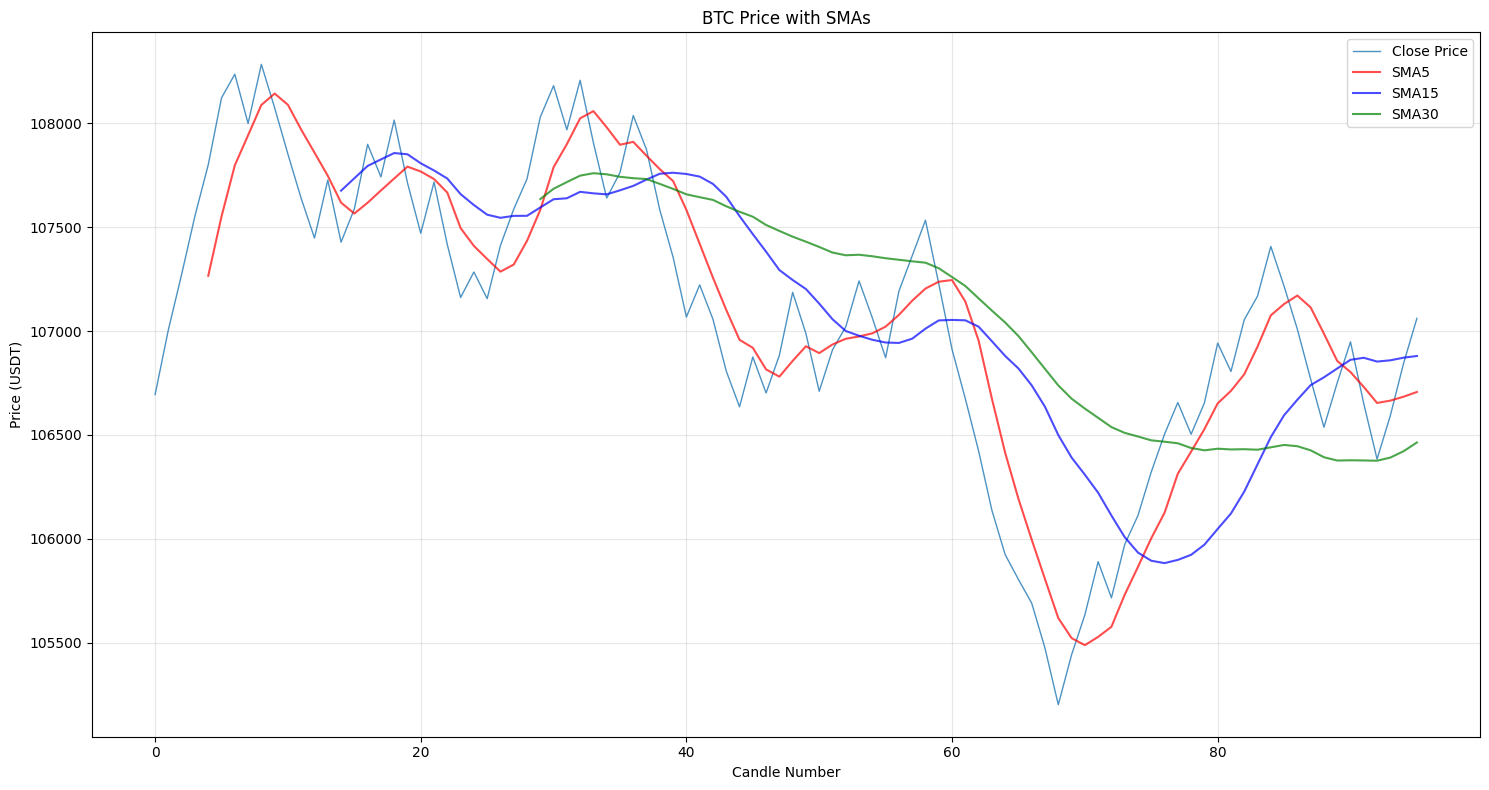

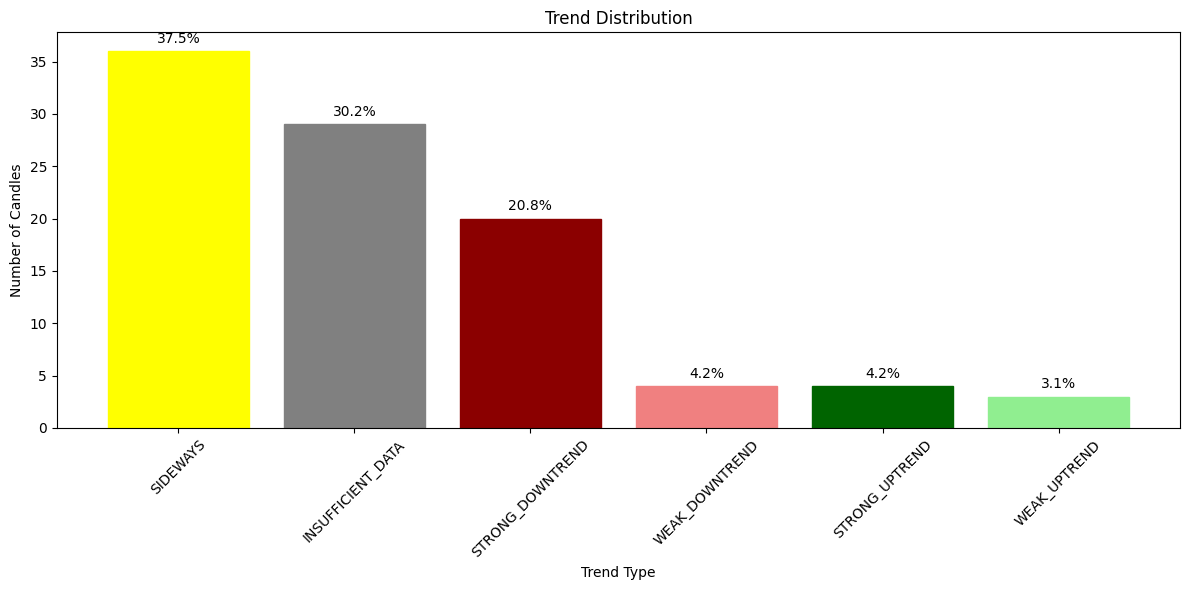

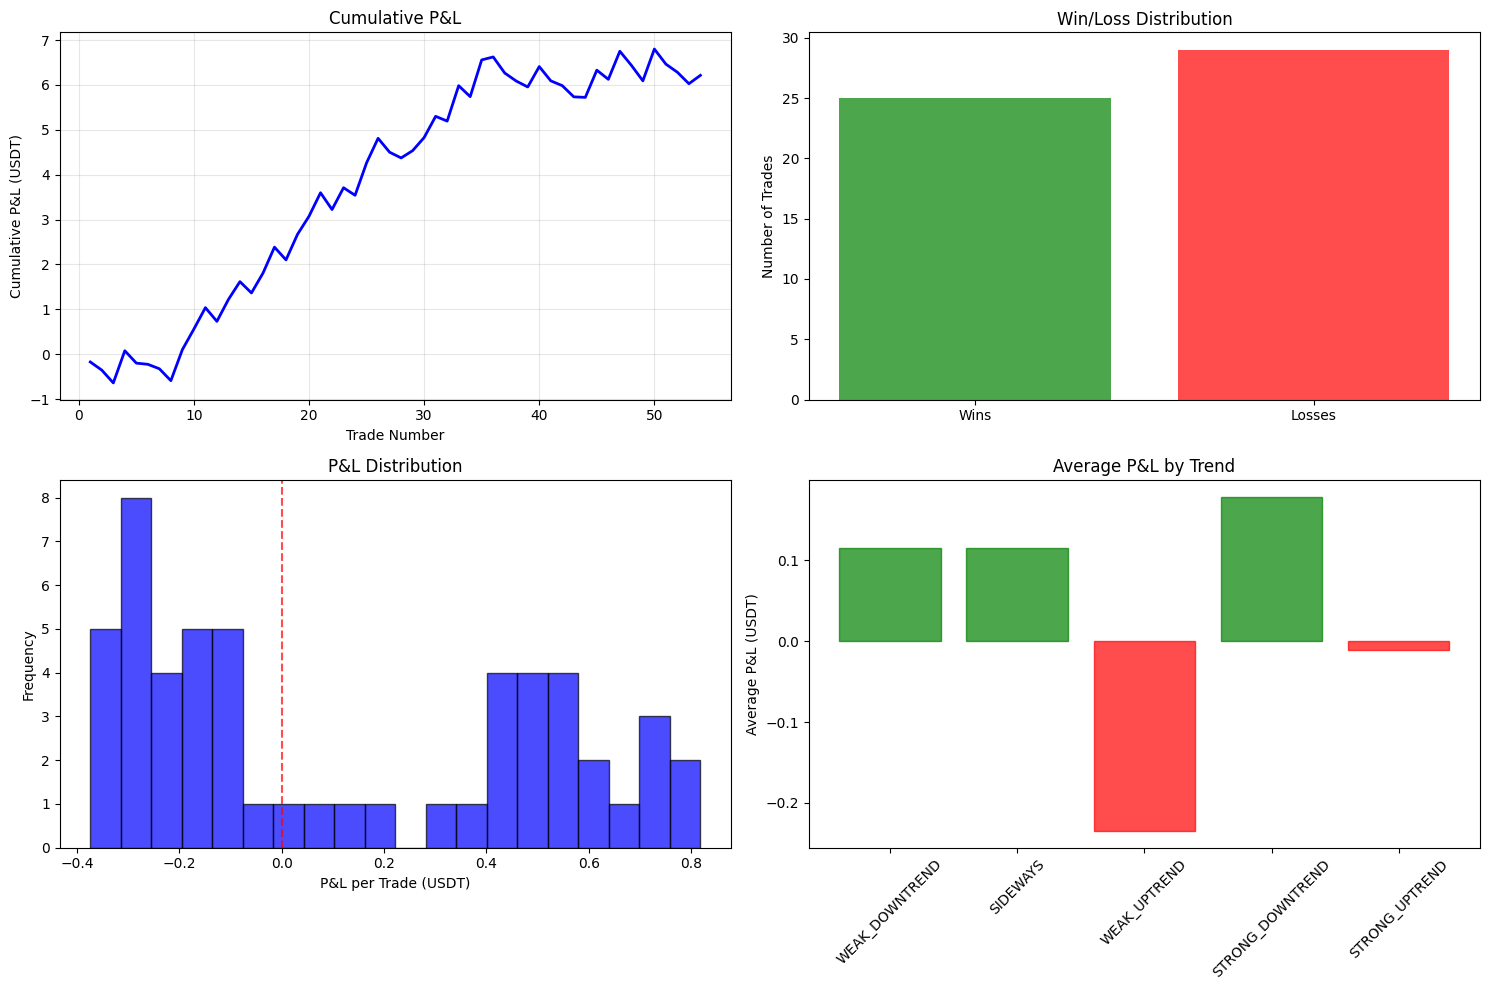


🎉 ANALYSIS COMPLETE!

✅ Notebook execution complete!
📝 You can now:
   - Modify CONFIG parameters and re-run
   - Analyze different scenarios
   - Export data for further analysis
   - Optimize strategy parameters


In [21]:
# === CELL 9: MAIN EXECUTION ===
def main():
    """Main execution function"""
    print("🚀 STARTING BTC SMA STRATEGY ANALYSIS")
    print("=" * 60)

    # Step 1: Generate data
    generator = BTCDataGenerator(CONFIG)
    df = generator.generate_candles()

    # Step 2: Calculate SMAs
    df = SMACalculator.calculate_sma(df, CONFIG['SMA_PERIODS'])

    # Step 3: Classify trends
    df = SMACalculator.add_trend_classification(df, CONFIG['TREND_THRESHOLD'])

    # Step 4: Apply spread strategy
    df = SpreadStrategy.apply_dynamic_spreads(df)

    # Step 5: Run trading simulation
    simulator = TradingSimulator(CONFIG)
    trades = simulator.run_simulation(df)

    # Step 6: Analyze performance
    metrics = PerformanceAnalyzer.calculate_metrics(
        trades,
        CONFIG['STARTING_BALANCE'],
        simulator.balance,
        simulator.total_trading_fees,
        simulator.total_funding_fees
    )
    PerformanceAnalyzer.analyze_by_trend(trades)
    PerformanceAnalyzer.display_sample_trades(trades)

    # Step 7: Visualizations
    print("\n📊 Generating visualizations...")
    Visualizer.plot_price_and_smas(df)
    Visualizer.plot_trend_distribution(df)
    if trades:
        Visualizer.plot_performance_metrics(trades, metrics)

    print("\n🎉 ANALYSIS COMPLETE!")
    print("=" * 60)

    return df, trades, metrics, simulator

# === CELL 10: RUN ANALYSIS ===
# Execute the complete analysis
df, trades, metrics, simulator = main()

# === CELL 11: OPTIONAL - DISPLAY DETAILED DATA ===
def display_detailed_analysis():
    """Display detailed data tables"""
    print("\n📊 DETAILED DATA ANALYSIS")
    print("=" * 50)

    # Display first 10 candles with all calculations
    print("\n📈 Sample Data (First 10 candles):")
    display_cols = ['candle', 'time', 'close', 'sma5', 'sma15', 'sma30',
                   'trend', 'bid_price', 'ask_price', 'spread_pct']
    print(df[display_cols].head(10).to_string(index=False))

    # Display candles with SMA30 data
    sma30_data = df[df['sma30'].notna()]
    if len(sma30_data) > 0:
        print(f"\n📊 Candles with SMA30 data (showing first 10 of {len(sma30_data)}):")
        print(sma30_data[display_cols].head(10).to_string(index=False))

    # Display all trades
    if trades:
        print(f"\n💼 All Trades ({len(trades)} total):")
        trades_df = pd.DataFrame(trades)
        display_trades_cols = ['id', 'side', 'entry_price', 'exit_price',
                              'exit_reason', 'final_pnl', 'trend_at_entry']
        if len(trades_df) <= 20:
            print(trades_df[display_trades_cols].to_string(index=False))
        else:
            print("First 20 trades:")
            print(trades_df[display_trades_cols].head(20).to_string(index=False))

# Uncomment the line below to see detailed data tables
# display_detailed_analysis()

print("\n✅ Notebook execution complete!")
print("📝 You can now:")
print("   - Modify CONFIG parameters and re-run")
print("   - Analyze different scenarios")
print("   - Export data for further analysis")
print("   - Optimize strategy parameters")


In [22]:
# === CELL 12: MULTIPLE SIMULATIONS COMPARISON ===
def run_multiple_simulations(n_runs=10):
    """Run multiple simulations to get average results"""
    print(f"\n🔄 RUNNING {n_runs} SIMULATIONS FOR STATISTICAL ANALYSIS")
    print("=" * 70)

    all_results = []
    original_seed = CONFIG['SEED']

    for run in range(n_runs):
        # Change seed for each run
        CONFIG['SEED'] = original_seed + run * 1000  # Ensure different random sequences

        print(f"📊 Run {run+1}/{n_runs} (Seed: {CONFIG['SEED']})...", end=" ")

        try:
            # Run simulation
            generator = BTCDataGenerator(CONFIG)
            df = generator.generate_candles()
            df = SMACalculator.calculate_sma(df, CONFIG['SMA_PERIODS'])
            df = SMACalculator.add_trend_classification(df, CONFIG['TREND_THRESHOLD'])
            df = SpreadStrategy.apply_dynamic_spreads(df)

            simulator = TradingSimulator(CONFIG)
            trades = simulator.run_simulation(df)

            # Calculate metrics
            if trades:
                winners = [t for t in trades if t.get('net_pnl', t['final_pnl']) > 0]
                win_rate = (len(winners) / len(trades)) * 100

                # Calculate profit factor
                gross_profit = sum(t.get('net_pnl', t['final_pnl']) for t in winners)
                gross_loss = abs(sum(t.get('net_pnl', t['final_pnl']) for t in trades if t.get('net_pnl', t['final_pnl']) <= 0))
                profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

                # Fee analysis
                total_fees = simulator.total_trading_fees + simulator.total_funding_fees
                maker_trades = len([t for t in trades if t.get('is_maker_entry', False)])
                maker_ratio = (maker_trades / len(trades)) * 100
            else:
                win_rate = 0
                profit_factor = 0
                total_fees = 0
                maker_ratio = 0

            # Store results
            result = {
                'run': run + 1,
                'seed': CONFIG['SEED'],
                'total_trades': len(trades),
                'final_balance': simulator.balance,
                'net_pnl': simulator.balance - CONFIG['STARTING_BALANCE'],
                'return_pct': ((simulator.balance - CONFIG['STARTING_BALANCE']) / CONFIG['STARTING_BALANCE']) * 100,
                'win_rate': win_rate,
                'profit_factor': profit_factor,
                'total_trading_fees': simulator.total_trading_fees,
                'total_funding_fees': simulator.total_funding_fees,
                'total_fees': total_fees,
                'maker_ratio': maker_ratio,
                'fee_impact_pct': (total_fees / CONFIG['STARTING_BALANCE']) * 100
            }
            all_results.append(result)

            print(f"✅ Return: {result['return_pct']:+.2f}%, Trades: {result['total_trades']}, WR: {result['win_rate']:.1f}%")

        except Exception as e:
            print(f"❌ Error: {str(e)}")
            continue

    if not all_results:
        print("❌ No successful runs completed")
        return None

    # Calculate statistics
    df_results = pd.DataFrame(all_results)

    print(f"\n📊 STATISTICAL ANALYSIS OVER {len(df_results)} SUCCESSFUL RUNS:")
    print("=" * 70)

    # Performance Statistics
    print("🎯 PERFORMANCE STATISTICS:")
    print(f"   Average Return: {df_results['return_pct'].mean():+.2f}% ± {df_results['return_pct'].std():.2f}%")
    print(f"   Best Return: {df_results['return_pct'].max():+.2f}%")
    print(f"   Worst Return: {df_results['return_pct'].min():+.2f}%")
    print(f"   Positive Returns: {len(df_results[df_results['return_pct'] > 0])}/{len(df_results)} ({len(df_results[df_results['return_pct'] > 0])/len(df_results)*100:.1f}%)")

    # Trading Statistics
    print(f"\n📈 TRADING STATISTICS:")
    print(f"   Average Trades: {df_results['total_trades'].mean():.1f} ± {df_results['total_trades'].std():.1f}")
    print(f"   Average Win Rate: {df_results['win_rate'].mean():.1f}% ± {df_results['win_rate'].std():.1f}%")
    print(f"   Average Profit Factor: {df_results['profit_factor'].mean():.2f} ± {df_results['profit_factor'].std():.2f}")
    print(f"   Average Maker Ratio: {df_results['maker_ratio'].mean():.1f}% ± {df_results['maker_ratio'].std():.1f}%")

    # Fee Analysis
    print(f"\n💸 FEE ANALYSIS:")
    print(f"   Average Total Fees: ${df_results['total_fees'].mean():.2f} ± ${df_results['total_fees'].std():.2f}")
    print(f"   Average Trading Fees: ${df_results['total_trading_fees'].mean():.2f}")
    print(f"   Average Funding Fees: ${df_results['total_funding_fees'].mean():.2f}")
    print(f"   Average Fee Impact: {df_results['fee_impact_pct'].mean():.3f}% of balance")

    # Strategy Assessment
    profitability_score = len(df_results[df_results['return_pct'] > 0]) / len(df_results)
    consistency_score = 1 - (df_results['return_pct'].std() / abs(df_results['return_pct'].mean())) if df_results['return_pct'].mean() != 0 else 0

    print(f"\n🎯 STRATEGY ASSESSMENT:")
    print(f"   Profitability Score: {profitability_score:.2f} (% of positive runs)")
    print(f"   Consistency Score: {max(0, consistency_score):.2f} (lower volatility = higher score)")

    if df_results['return_pct'].mean() > 0.5 and profitability_score > 0.6:
        print("   ✅ Strategy shows POSITIVE potential")
    elif df_results['return_pct'].mean() > 0 and profitability_score > 0.5:
        print("   ⚠️  Strategy shows MODERATE potential")
    else:
        print("   ❌ Strategy shows WEAK potential")

    # Restore original seed
    CONFIG['SEED'] = original_seed

    return df_results

def quick_strategy_comparison():
    """Quick comparison of different strategy parameters"""
    print(f"\n🔬 QUICK STRATEGY PARAMETER COMPARISON")
    print("=" * 60)

    original_config = CONFIG.copy()
    scenarios = [
        {"name": "Current", "changes": {}},
        {"name": "Lower Fees", "changes": {"TAKER_FEE": 0.0003, "MAKER_FEE": 0.0001}},
        {"name": "Larger Position", "changes": {"POSITION_SIZE": 0.0007}},
        {"name": "Wider TP/SL", "changes": {"TAKE_PROFIT": 0.0012, "STOP_LOSS": 0.0005}},
    ]

    comparison_results = []

    for scenario in scenarios:
        print(f"\n📊 Testing: {scenario['name']}")

        # Apply changes
        for key, value in scenario['changes'].items():
            CONFIG[key] = value

        # Run 5 quick simulations
        returns = []
        for i in range(5):
            CONFIG['SEED'] = 12345 + i * 500

            generator = BTCDataGenerator(CONFIG)
            df = generator.generate_candles()
            df = SMACalculator.calculate_sma(df, CONFIG['SMA_PERIODS'])
            df = SMACalculator.add_trend_classification(df, CONFIG['TREND_THRESHOLD'])
            df = SpreadStrategy.apply_dynamic_spreads(df)

            simulator = TradingSimulator(CONFIG)
            trades = simulator.run_simulation(df)

            return_pct = ((simulator.balance - CONFIG['STARTING_BALANCE']) / CONFIG['STARTING_BALANCE']) * 100
            returns.append(return_pct)

        avg_return = np.mean(returns)
        comparison_results.append({
            'scenario': scenario['name'],
            'avg_return': avg_return,
            'std_return': np.std(returns),
            'config_changes': scenario['changes']
        })

        print(f"   Average Return: {avg_return:+.2f}% ± {np.std(returns):.2f}%")

        # Restore original config
        for key in scenario['changes']:
            CONFIG[key] = original_config[key]

    # Show comparison
    print(f"\n🏆 SCENARIO RANKING:")
    comparison_results.sort(key=lambda x: x['avg_return'], reverse=True)
    for i, result in enumerate(comparison_results):
        print(f"   {i+1}. {result['scenario']}: {result['avg_return']:+.2f}%")

    return comparison_results

    # === CELL 13: EXECUTE MULTIPLE SIMULATIONS ===
print("\n" + "="*60)
print("🚀 MULTIPLE SIMULATIONS ANALYSIS")
print("="*60)

# Option 1: Run detailed multiple simulations
print("\n💡 To run multiple simulations, execute:")
print("   results = run_multiple_simulations(10)")
print("   # This will run 10 simulations with different seeds")

# Option 2: Run quick comparison
print("\n💡 To compare strategy variations, execute:")
print("   comparison = quick_strategy_comparison()")
print("   # This will test different parameter sets")

# Uncomment below to automatically run multiple simulations
# print("\n🔄 Auto-running 5 quick simulations...")
# results = run_multiple_simulations(5)

print("\n✅ Notebook execution complete!")


🚀 MULTIPLE SIMULATIONS ANALYSIS

💡 To run multiple simulations, execute:
   results = run_multiple_simulations(10)
   # This will run 10 simulations with different seeds

💡 To compare strategy variations, execute:
   comparison = quick_strategy_comparison()
   # This will test different parameter sets

✅ Notebook execution complete!


In [23]:
results = run_multiple_simulations(10)



🔄 RUNNING 10 SIMULATIONS FOR STATISTICAL ANALYSIS
📊 Run 1/10 (Seed: 12345)... 
🔢 Generating BTC price data...
✅ Generated 96 candles
📈 Price range: $105182.98 - $108327.59
💹 Total movement: 0.06%
💰 Avg funding rate: 0.000092 (0.0092%)

📊 Calculating SMAs...
   SMA5: 92 valid values
   SMA15: 82 valid values
   SMA30: 67 valid values

🎯 Classifying trends...
📈 Trend Distribution:
   SIDEWAYS: 36 candles (37.5%)
   INSUFFICIENT_DATA: 29 candles (30.2%)
   STRONG_DOWNTREND: 20 candles (20.8%)
   WEAK_DOWNTREND: 4 candles (4.2%)
   STRONG_UPTREND: 4 candles (4.2%)
   WEAK_UPTREND: 3 candles (3.1%)

💰 Applying dynamic spread strategy...
✅ Dynamic spreads applied

📊 Spread Strategy Configuration:
   STRONG_UPTREND: Bid=0.05%, Ask=0.20%
   WEAK_UPTREND: Bid=0.07%, Ask=0.15%
   SIDEWAYS: Bid=0.10%, Ask=0.10%
   WEAK_DOWNTREND: Bid=0.15%, Ask=0.07%
   STRONG_DOWNTREND: Bid=0.20%, Ask=0.05%
   INSUFFICIENT_DATA: Bid=0.10%, Ask=0.10%

🤖 Running trading simulation...
💰 Starting balance: $1000.00 

In [24]:
comparison = quick_strategy_comparison()



🔬 QUICK STRATEGY PARAMETER COMPARISON

📊 Testing: Current

🔢 Generating BTC price data...
✅ Generated 96 candles
📈 Price range: $105182.98 - $108327.59
💹 Total movement: 0.06%
💰 Avg funding rate: 0.000092 (0.0092%)

📊 Calculating SMAs...
   SMA5: 92 valid values
   SMA15: 82 valid values
   SMA30: 67 valid values

🎯 Classifying trends...
📈 Trend Distribution:
   SIDEWAYS: 36 candles (37.5%)
   INSUFFICIENT_DATA: 29 candles (30.2%)
   STRONG_DOWNTREND: 20 candles (20.8%)
   WEAK_DOWNTREND: 4 candles (4.2%)
   STRONG_UPTREND: 4 candles (4.2%)
   WEAK_UPTREND: 3 candles (3.1%)

💰 Applying dynamic spread strategy...
✅ Dynamic spreads applied

📊 Spread Strategy Configuration:
   STRONG_UPTREND: Bid=0.05%, Ask=0.20%
   WEAK_UPTREND: Bid=0.07%, Ask=0.15%
   SIDEWAYS: Bid=0.10%, Ask=0.10%
   WEAK_DOWNTREND: Bid=0.15%, Ask=0.07%
   STRONG_DOWNTREND: Bid=0.20%, Ask=0.05%
   INSUFFICIENT_DATA: Bid=0.10%, Ask=0.10%

🤖 Running trading simulation...
💰 Starting balance: $1000.00 USDT
⚡ Leverage: 5x
